### Hybrid Variational Neural Network for Fano fitting (Quantum-Classical Variational Neural Network)

<p>Perform a regression to fit a Fano resonance with Pennylane framework</p>

<p> Let's fit a <a href="https://en.wikipedia.org/wiki/Fano_resonance">Fano resonance</a>, this signal appears on superconducting resonators when photons<sup><a href="https://arxiv.org/abs/2207.03829">[1]</a></sup> interact with spins at low temperatures (from 4K to 10mK in a dilution refrigerator)</p>

#### References:

> https://arxiv.org/abs/2207.03829
>
> https://qiskit.org/documentation/machine-learning/tutorials/06_torch_runtime.html

In [1]:
from torch import Tensor, manual_seed, is_tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS, Adam
from torch.utils.data import Dataset, DataLoader

from qiskit import Aer, QuantumCircuit
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.opflow import AerPauliExpectation
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import CircuitQNN, TwoLayerQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.runtime import TorchRuntimeClient, TorchRuntimeResult

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.ndimage import gaussian_filter
from scipy.signal import detrend
from sklearn.preprocessing import StandardScaler
import warnings

warnings.filterwarnings('ignore')

%matplotlib inline

plt.rcParams['figure.figsize'] = [10, 7]
%config InlineBackend.figure_format = 'retina'

In [4]:
# Set seed for random generators
seed = 42
manual_seed(seed)
algorithm_globals.random_seed = seed

In [5]:
fano_data = pd.read_csv("./datasets/signal_080_peak_1_fano_adjust.csv")

In [6]:
def func_fano(x, xc, w, q, y0):
    y = y0+A*(2*(x-xc)/w+q)*(2*(x-xc)/w+q)/(2*(x-xc)/w*2*(x-xc)/w+1)/(1+q*q)
    return y

def scale(arr, lvalue = -np.pi, rvalue = np.pi):
    return np.interp(arr, (arr.min(), arr.max()), (lvalue, rvalue))

def remove_outlier(df_in, col_name, quartiles, rng_arr):
    q1 = df_in[col_name].quantile(quartiles[0])
    q3 = df_in[col_name].quantile(quartiles[1])
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-rng_arr[0]*iqr
    fence_high = q3+rng_arr[1]*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

In [7]:
def smooth(data):
    #return data
    #return scipy.ndimage.gaussian_filter(data, sigma=30, mode='reflect', truncate=18.0)
    
    return gaussian_filter(data, sigma=15, mode='reflect', truncate=18.0)
    #return scipy.ndimage.gaussian_filter(data, sigma=15, mode='reflect', truncate=15.0)

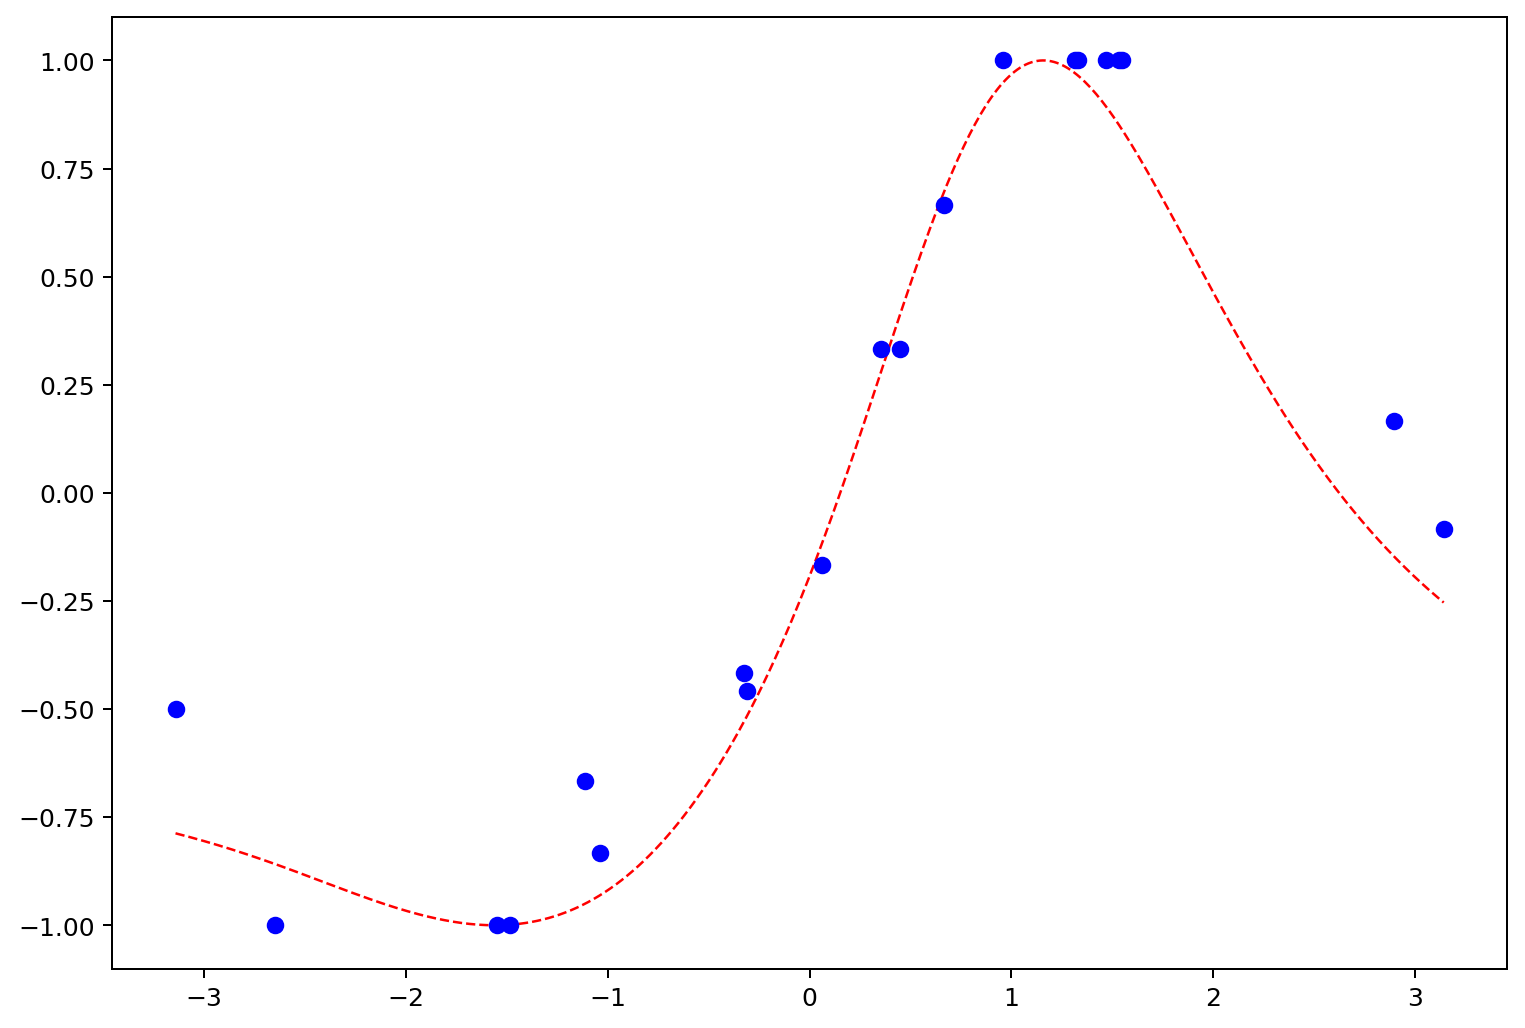

In [8]:
num_samples = 20
eps = 0.2
lb, ub = -1, 1

y0 = fano_data["y0"].values[0]
A = fano_data["A"].values[0]
xc = fano_data["xc"].values[0]
q = fano_data["q"].values[0]
w = fano_data["w"].values[0]

f = lambda x: func_fano(x, xc, w, q, y0)

X_ = fano_data["signal_original_x"].values.reshape(-1,1)

# Create Gaussian distribution (mean = 0, std = 1)
std_scaler = StandardScaler()
std_scaler.fit(X_)
X_ = std_scaler.transform(X_)

#y_ = f(X_)

y_ = fano_data["signal_original_y"].values

# select a better range of data to fit
rng = range(250,700)

X_ = X_.take(rng, axis=0)
y_ = y_.take(rng, axis=0)

# random indices for points selection
#indices = sorted(np.random.choice(range(X_.shape[0]), num_samples, replace=False))

#indices = np.array([19,  40, 156, 159, 173, 175, 191, 207, 213, 253, 358, 359, 448, 543, 559, 613, 651, 657, 737, 754])
indices = [22, 54, 125, 129, 153, 158, 204, 205, 229, 248, 254, 268, 287, 310, 311, 320, 324, 325, 412, 428]

XX = X_[indices].reshape(-1,1)
yy = y_[indices].reshape(-1,1)

#df = pd.DataFrame(zip(X[:,0].flatten().tolist(), y[:,0].flatten().tolist()), columns = ["X", "y"])
#new_df = remove_outlier(df, "y", [0.25, 0.75], [0.05, 0.05])
#X = new_df["X"].values.reshape(-1,1)
#y = new_df["y"].values.reshape(-1,1)

yy = detrend(yy)

#XX = scale(XX, 0, 1)
XX = scale(XX) # from -pi to pi
yy = scale(yy, -1, 1)

#X_ = scale(X_, 0, 1)
X_ = scale(X_) # from -pi to pi
y_ = scale(y_, -1, 1)

plt.figure(num = "Fano adjust data", figsize = (10, 7), dpi=90, facecolor='w', edgecolor='k')
plt.plot(X_, y_, "r--", label='Tx signal', linewidth = 1)
plt.plot(XX, yy, "bo", label = 'Points to fit')
plt.show()

In [9]:
# Create custom torch dataset class
class TorchDataset(Dataset):
    """Map-style dataset"""

    def __init__(self, X, y):
        self.X = Tensor(X).float()
        self.y = Tensor(y).float()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        import torch

        if torch.is_tensor(idx):
            idx = idx.tolist()

        X_i = self.X[idx]
        y_i = self.y[idx]

        # important: the dataset item must be returned as data,target
        return X_i, y_i

In [10]:
# Create a train loader
train_set = TorchDataset(XX, yy)
train_loader1 = DataLoader(train_set, batch_size=1, shuffle=False, pin_memory=False)

In [11]:
from qiskit.circuit import Parameter

# Construct simple feature map
param_x = Parameter("x")
feature_map = QuantumCircuit(1, name="fm")
feature_map.ry(param_x, 0)

# Construct simple feature map
param_y = Parameter("y")
ansatz = QuantumCircuit(1, name="vf")
ansatz.ry(param_y, 0)

# Construct QNN
qnn1 = TwoLayerQNN(1, feature_map, ansatz)
print(qnn1.operator)

initial_weights = 0.1 * (2 * algorithm_globals.random.random(qnn1.num_weights) - 1)
model1 = TorchConnector(qnn1, initial_weights)

# Define optimizer and loss function
optimizer1 = Adam(model1.parameters(), lr=0.1)
loss_func1 = MSELoss(reduction="sum")

ComposedOp([
  OperatorMeasurement(1.0 * Z),
  CircuitStateFn(
     ┌───────┐┌───────┐
  q: ┤ fm(x) ├┤ vf(y) ├
     └───────┘└───────┘
  )
])


In [12]:
# Set up a provider and backend
from qiskit import IBMQ

IBMQ.load_account()

provider = IBMQ.get_provider(project="main")  # replace by your runtime provider
backend = provider.get_backend("ibmq_qasm_simulator")  # select a backend that supports the runtime

In [13]:
torch_runtime_client = TorchRuntimeClient(
    provider=provider,
    model=model1,
    optimizer=optimizer1,
    loss_func=loss_func1,
    epochs=5,
    backend=backend,
)

In [14]:
from qiskit_machine_learning.runtime import HookBase

class StopHook(HookBase):
    """For early stopping"""

    def __init__(self, loss_threshold):
        self._loss_threshold = loss_threshold

    def after_epoch(self):
        
        # This function is called after each epoch
        current_loss = self.trainer.train_logger.metrics[-1]["loss"]
        print("current loss: ", current_loss)
        
        # If current loss is smaller than the threshold,
        # set the current number of the epoch to the maximum number of the epochs to stop the training
        if current_loss < self._loss_threshold:
            self.trainer.epoch = self.trainer.max_epochs

In [15]:
stop_hook = StopHook(loss_threshold=0.05)

In [ ]:
fit_result = torch_runtime_client.fit(train_loader=train_loader1, hooks=stop_hook)

In [ ]:
print("id: ", fit_result.job_id)
print("execution time: ", fit_result.execution_time)

print("train history: ")
for epoch_result in fit_result.train_history:
    print("  epoch", epoch_result["epoch"], ": loss", epoch_result["loss"])

In [ ]:
predict_result = torch_runtime_client.predict(data_loader=test_loader)

In [ ]:
print("id: ", predict_result.job_id)
print("execution time: ", predict_result.execution_time)

In [ ]:
# Plot the original function
plt.plot(X_, y_, "r--", label='Tx signal', linewidth = 1)

# Plot the training data
plt.plot(XX, yy, "bo")

# # Plot the prediction result
y_ = []
for output in predict_result.prediction:
    y_.append(output.item())
    
plt.plot(X_, y_, "g-")
plt.show()

In [ ]:
score_result = torch_runtime_client.score(data_loader=test_loader, score_func="regression")

In [ ]:
print("id: ", score_result.job_id)
print("execution time: ", score_result.execution_time)
print("score: ", score_result.score)